본 프로젝트는 영국 중고차 시장 데이터를 분석하여 가격 형성 요인과 시장 특성을 파악하고,

이를 기반으로 브랜드별 마케팅 전략 수립에 활용하는 것을 목표로 한다.

세부목표:

- cars.csv와 brand.csv를 결합하여 완전한 분석용 데이터 구성

- 결측치 및 이상치 처리로 데이터 정제

- 범주형 변수의 수치화

- Scaler 및 PCA를 통해 주요 요인 도출

- 시장 분석 결과를 바탕으로 마케팅 시사점 도출

In [48]:
import pandas as pd

# 데이터 불러오기
url_cars = 'https://raw.githubusercontent.com/blackleft/cars/refs/heads/main/cars.csv'
url_brand = 'https://raw.githubusercontent.com/blackleft/cars/refs/heads/main/brand.csv'

cars = pd.read_csv(url_cars)
brand = pd.read_csv(url_brand)

print("cars.csv:", cars.shape)
print("brand.csv:", brand.shape)

display(cars.head())
display(brand.head())

cars.csv: (3687, 13)
brand.csv: (48, 2)


,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,HYUNDAI I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,VAUXHALL CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN


,title,country
0,skoda,Czech Republic
1,vauxhall,United Kingdom
2,hyundai,South Korea
3,mini,United Kingdom
4,ford,United States


<데이터 병합>

의도:

데이터의 형태, 크기, 주요 컬럼을 파악하여 이후 병합 전략을 세움.

결과 해석:

두 데이터셋의 공통 키(brand 혹은 title 기반)를 활용해 병합할 준비가 완료됨.

In [49]:
# title에서 브랜드명 추출
cars['Brand'] = cars['title'].str.split().str[0]
merged = pd.merge(cars, brand, left_on='Brand', right_on='title', how='left')
print("병합 완료:", merged.shape)
display(merged.head())

병합 완료: (3687, 16)


,title_x,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,Brand,title_y,country
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN,SKODA,NaN,NaN
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full,VAUXHALL,NaN,NaN
2,HYUNDAI I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN,HYUNDAI,NaN,NaN
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full,MINI,NaN,NaN
4,VAUXHALL CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN,VAUXHALL,NaN,NaN


현재 병합 결과를 보면, 구조는 정상적으로 합쳐졌지만
브랜드명이 정확히 일치하지 않아 일부 정보가 누락되어 있음.
이는 cars.csv의 브랜드명이 모두 대문자로 되어 있고,
brand.csv의 브랜드명은 소문자이기 때문
따라서 대소문자를 통일한 뒤 재병합하면 브랜드별 국가 정보가 정상적으로 연결될 것이다.

In [50]:
# 대소문자 통일
cars['Brand'] = cars['Brand'].str.lower()
brand['title'] = brand['title'].str.lower()

merged['country'].isnull().sum()

# 병합
merged = pd.merge(cars, brand, left_on='Brand', right_on='title', how='left')

# 병합 확인
print("병합 완료:", merged.shape)
print("country 결측치 개수:", merged['country'].isnull().sum())
display(merged[['Brand', 'country']].head(10))

병합 완료: (3687, 16)
country 결측치 개수: 0


,Brand,country
0,skoda,Czech Republic
1,vauxhall,United Kingdom
2,hyundai,South Korea
3,mini,United Kingdom
4,vauxhall,United Kingdom
5,hyundai,South Korea
6,ford,United States
7,vauxhall,United Kingdom
8,volvo,Sweden
9,peugeot,France


대소문자 통일 후 country 컬럼의 결측치 개수가 0개로 나타남.

이는 모든 차량 데이터가 brand.csv의 국가 정보와 완벽히 매칭되었음을 의미함.

<카테고리형 변수를 숫자 형태로 변환>

이번 단계의 목적은 텍스트 기반 수치 데이터를 실제 수치형 변수로 변환하여 분석 가능한 형태로 만드는 것이다.

Engine과 Emission Class 변수는 본래 문자열로 저장되어 있었지만, 실제로는 차량의 엔진 크기와 배출가스 기준 등급을 나타내는 수치형 변수이다.

이에 따라 각 변수에서 단위 문자를 제거하고 숫자형으로 변환하였다.

In [62]:
# Engine에서 'L' 문자 제거 후 숫자로 변환
merged['Engine'] = merged['Engine'].astype(str).str.replace('L', '', regex=False)
merged['Engine'] = pd.to_numeric(merged['Engine'], errors='coerce')

# Emission Class에서 'Euro' 제거 후 숫자 추출
merged['Emission Class'] = merged['Emission Class'].astype(str).str.replace('Euro ', '', regex=False)
merged['Emission Class'] = pd.to_numeric(merged['Emission Class'], errors='coerce')

merged[['Engine', 'Emission Class']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Engine          3642 non-null   float64
 1   Emission Class  3600 non-null   float64
dtypes: float64(2)
memory usage: 57.7 KB


변환 완료 후, 데이터셋은 정량 분석에 적합한 형태로 정리되었으며, 숫자로 표현하지 못할 경우에 NaN(결측치)로 바꿈.

- 데이터 전체 행: 3687개

- Engine 값이 있는 행: 3642개/45개 결측(NaN)

- Emission Class 값이 있는 행: 3600개/87개 결측(NaN)

이후 단계인 결측치 처리(Unknown, 중앙값 대체) 및 상관관계 분석을 수행할 준비가 되었음.

<결측치 처리하기>

데이터 내 결측치를 처리하여 분석의 신뢰성과 일관성을 확보하기 위함.


- Service history 변수의 결측치는 "Unknown"으로 채운다.

- 결측치가 일정 개수 이상 포함된 데이터(행)는 제거한다.

- 나머지 결측치는 중앙값으로 대체하여 수치적 왜곡을 최소화한다.

이를 통해 데이터 손실은 최소화하면서도 품질을 유지하는 전처리를 수행함.

In [63]:
# Service history, Previous Owners → 'Unknown'으로 대체
merged['Service history'] = merged['Service history'].fillna('Unknown')
merged['Previous Owners'] = merged['Previous Owners'].fillna('Unknown')

# 결측치가 일정 개수(3개) 이상 포함된 행은 제거
merged = merged[merged.isnull().sum(axis=1) < 3]

# 나머지 수치형 변수 결측치는 중앙값으로 대체
num_cols = ['Engine', 'Doors', 'Seats', 'Emission Class']
for col in num_cols:
    merged[col] = merged[col].fillna(merged[col].median())

# 결과 확인
print("결측치 처리 완료")
print(merged.isnull().sum())
print("처리 후 데이터 크기:", merged.shape)


결측치 처리 완료
title_x              0
Price                0
Mileage(miles)       0
Registration_Year    0
Previous Owners      0
Fuel type            0
Body type            0
Engine               0
Gearbox              0
Doors                0
Seats                0
Emission Class       0
Service history      0
Brand                0
title_y              0
country              0
dtype: int64
처리 후 데이터 크기: (3672, 16)


결과 해석 :
모든 변수의 결측치 : 0개
데이터 크기 (3672, 16) : 행 3672개, 열 16개

결측치 처리 결과,

모든 변수의 결측값이 제거되어 완전한 데이터셋이 확보됨.
Service history와 Previous Owners는 "Unknown"으로 대체되어 의미 있는 범주로 보존함.

결측치가 3개 이상이던 행은 제거되어 데이터 품질이 향상되었으며,

수치형 변수(Engine, Doors, Seats, Emission Class)는 중앙값으로 대체하여 안정성을 유지함.


최종 데이터는 총 3672행 × 16열로,
이후 분석(상관관계, 시각화, PCA 등)에 활용 가능한 상태이다.

<상관관계 분석>

이번 단계에서는 중고차 가격(Price) 과 다른 주요 변수들 간의 관계를 파악하여,
어떤 요인이 가격에 가장 큰 영향을 주는지를 이해하고자 함

=== Price 기준 상관관계 ===
Price                1.000000
Registration_Year    0.726246
Emission Class       0.695129
Doors                0.113321
Engine              -0.024150
Seats               -0.027549
Mileage(miles)      -0.500788
Name: Price, dtype: float64


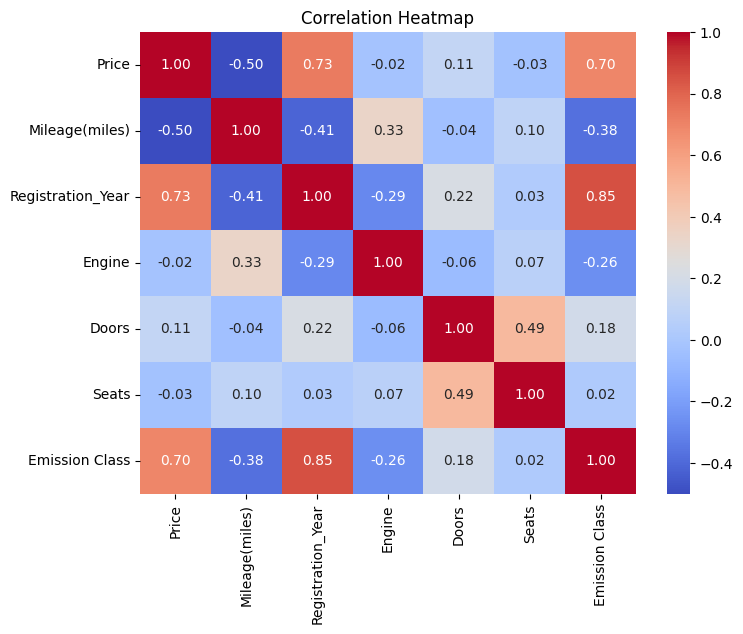

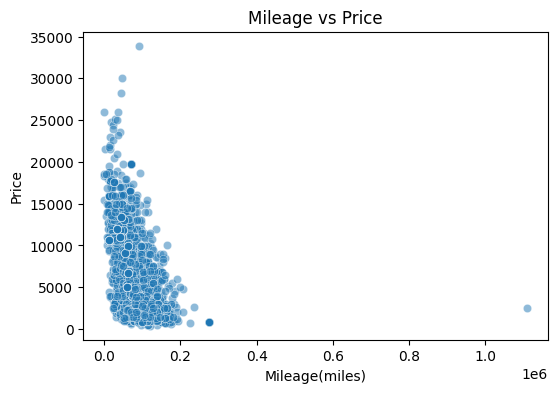

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns


num_cols = ['Price', 'Mileage(miles)', 'Registration_Year',
            'Engine', 'Doors', 'Seats', 'Emission Class']

# 상관계수 계산
corr = merged[num_cols].corr()

print("=== Price 기준 상관관계 ===")
print(corr['Price'].sort_values(ascending=False))

# 히트맵
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# 산점도(가격과 거리 관계)
plt.figure(figsize=(6,4))
sns.scatterplot(data=merged, x='Mileage(miles)', y='Price', alpha=0.5)
plt.title('Mileage vs Price')
plt.show()


결과 :

- Registration_Year(0.73, 강한 양의 상관) : 최근 연식일수록 차량 가격이 높게 형성되는 경향이 있음
- Emission Class(0.70, 강한 양의 상관) : 배출가스 등급이 높을수록 차량 가격도 높음
- Mileage(miles)(-0.50, 중간 정도 음의 상관) :	주행거리가 많을수록 차량 가치가 떨어지는 경향
- Doors, Engine, Seats(0.1 이하의 매우 약한 상관) : 가격에 큰 영향 없음

해석 :

중고차 가격에 가장 큰 영향을 주는 요인은 연식(Registration_Year) 과 배출가스 등급(Emission Class), 그리고 주행거리(Mileage) 로 확인됨.

이는 신형 차량일수록, 배출가스 등급이 높을수록, 주행거리가 짧을수록 가격이 높다는 현실적인 시장 패턴과 일치하는 경향이 있음.

<Scaler 활용 및 PCA(주성분 분석)>

이번 단계에서는 변수들의 단위를 맞추기 위해 스케일링(Scaling) 을 수행하고,

이후 PCA(주성분 분석) 을 적용하여 데이터의 주요 패턴만 추출하고자 하였다.

데이터에는 가격(Price), 주행거리(Mileage), 엔진(Engine), 연식(Registration_Year) 등
단위가 모두 다른 여러 수치형 변수가 존재하기 때문에,

그대로 비교하면 특정 변수가 분석 결과를 왜곡할 수 있다.

이를 방지하기 위해 스케일링을 먼저 진행하였다.

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# 수치형 변수 선택
num_cols = ['Price', 'Mileage(miles)', 'Registration_Year', 'Engine', 'Doors', 'Seats', 'Emission Class']

X = merged[num_cols]

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

스케일링은 각 변수의 단위를 통일해주는 과정이다.

StandardScaler()를 사용하면 모든 변수를 평균 0, 표준편차 1로 변환한다.

이 과정을 통해 PCA는 변수 간의 크기 차이가 아닌 패턴의 유사성만 비교할 수 있게 된다.

In [71]:
# PCA 적용
pca = PCA()
pca.fit(X_scaled)

print("설명 분산 비율:", pca.explained_variance_ratio_)
print("누적 설명 비율:", pca.explained_variance_ratio_.cumsum())

설명 분산 비율: [0.42393875 0.21470792 0.1451146  0.09541539 0.06887983 0.03194723
 0.01999628]
누적 설명 비율: [0.42393875 0.63864667 0.78376128 0.87917667 0.9480565  0.98000372
 1.        ]


Scaler로 단위를 통일한 덕분에, PCA가 변수의 크기가 아닌 패턴의 관계를 분석할 수 있었다.

PCA는 데이터 내에서 함께 변하는 변수(즉, 상관관계가 높은 변수) 들을
하나의 축(주성분, Principal Component)으로 묶는 방식이다.
따라서 가격과 밀접하게 연관된 변수들이 같은 주성분에 포함되는 것은 자연스러운 결과이다.

PCA 결과, 7개 변수 중 3개 주성분만으로도 전체 정보의 약 78%를 설명 가능했다.

이는 “중복된 변수들이 많고, 주요 패턴이 몇 가지로 요약된다”는 의미로 해석된다.

<PCA 시각화 및 주성분 해석>

앞선 단계에서 PCA를 통해 주요 3개 주성분으로 전체 데이터의 약 78%를 설명할 수 있음을 확인했다.

이번 단계에서는 PCA 결과를 시각화하여 변수 간의 패턴이 실제로 어떻게 분포하는지를 살펴본다.

특히 첫 번째 주성분(PC1) 과 두 번째 주성분(PC2) 을 중심으로 시각화하면
데이터의 전반적인 구조를 한눈에 확인할 수 있다.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

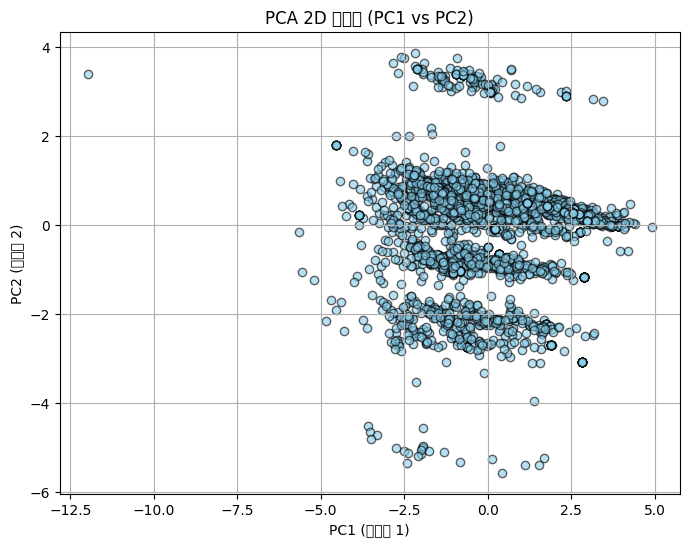

In [74]:
# PCA를 2차원으로 축소
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=X_pca_2d, columns=['PC1', 'PC2'])

# 시각화
plt.figure(figsize=(8,6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.6, color='skyblue', edgecolors='k')
plt.title('PCA 2D 시각화 (PC1 vs PC2)')
plt.xlabel('PC1 (주성분 1)')
plt.ylabel('PC2 (주성분 2)')
plt.grid(True)
plt.show()

결과해석 :

이전 단계에서 수행한 상관관계 분석 결과, 중고차 가격(Price)에 가장 큰 영향을 주는 변수는 연식(Registration_Year), 배출가스 등급(Emission Class), 주행거리(Mileage) 로 나타났다.

이 변수들은 서로 밀접하게 관련되어 있으며,
신형 차량일수록 등급이 높고, 주행거리가 짧으며, 가격이 높게 형성되는 경향이 있다.

이러한 패턴은 PCA(주성분 분석) 결과에서도 동일하게 반영되었다.

================================

- PC1 (주성분 1)
구성 변수: Price, Registration_Year, Emission Class (+), Mileage (−)

해석:
차량의 신형 정도 / 품질 수준을 나타내는 축
신차일수록 배출가스 등급이 높고, 주행거리는 짧으며, 가격이 높게 형성되는 패턴을 반영한다.


- PC2 (주성분 2)
구성 변수: Engine, Doors, Seats

해석:
차량의 크기 및 형태(차종 특성)을 나타내는 축으로,
대형 차량일수록 엔진 크기가 크고, 문 개수와 좌석 수도 많다는 패턴을 보여준다.

===============================


PCA 시각화 결과,
중고차 데이터가 몇 가지 주요 패턴(신형 정도, 차량 크기 등)에 따라 구분되는 것을 확인할 수 있었다.

대부분의 차량은 중심 근처에 밀집되어 있으나, 일부 차량은 양쪽 끝으로 퍼져 있다.

이는 대부분의 차량이 유사한 스펙을 가지지만,
일부는 가격이나 엔진 크기 등에서 독특한 특성을 보인다는 의미이다.

즉, 중고차 시장은 연식·가격·차량 크기 등의 요인에 따라 자연스럽게 그룹화되는 경향이 있음을 알 수 있다.

<시장 분석>
PCA 분석과 시각화 결과를 종합하면,
영국 중고차 시장은 연식(Registration_Year), 가격(Price), 배출가스 등급(Emission Class),
그리고 차량 크기(Engine, Doors, Seats) 를 중심으로 명확한 시장 구분이 존재함을 확인할 수 있었다.

이를 통해 시장은 '신형·고가 차량 중심', '중형·보급형 중고차', '노후·저가 차량'등으로 구분되며,
이러한 결과는 브랜드별 포지셔닝 전략 수립 및 마케팅 방향 설정에 직접적으로 활용 가능하다.

<회고>

이번 프로젝트를 통해 단순히 데이터 정제와 시각화 단계를 넘어, 통계적 요약(PCA)을 통한 시장 구조 파악의 실제 활용성을 체감했다.

또한 PCA 결과를 시각화함으로써 단순히 수치로 표현된 데이터가 아닌, 시장 내 차량 분포를 시각적으로 이해하고 전략적으로 활용할 수 있다는 점이 인상적이었다.

앞으로는 이러한 분석을 기반으로 브랜드별 최적 가격 예측 또는 수요 예측으로 발전시켜보면 좋을 것 같다.

<국가별 총 브랜드 개수 확인>

브랜드 데이터와 병합한 결과를 이용해, 각 나라(country)별로 보유한 브랜드 수를 확인함으로써

영국 중고차 시장에서의 국가별 자동차 브랜드 다양성을 파악한다.

country
Japan             11
United Kingdom     8
Germany            6
United States      5
France             4
Italy              4
South Korea        4
Sweden             2
Czech Republic     1
Malaysia           1
Romania            1
Spain              1
Name: Brand, dtype: int64


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

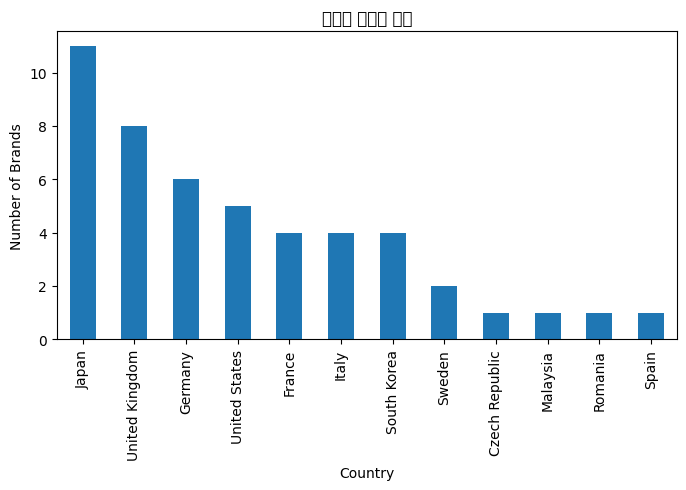

In [76]:
# 국가별 브랜드 개수 집계
country_brand_count = merged.groupby('country')['Brand'].nunique().sort_values(ascending=False)
print(country_brand_count)

# 시각화
country_brand_count.plot(kind='bar', figsize=(8,4), title='국가별 브랜드 개수')
plt.xlabel('Country')
plt.ylabel('Number of Brands')
plt.show()

결과해석 :

일본은 브랜드 수에서 압도적 1위이다. 보급형·경제형 차량 시장에서 점유율이 높음.

영국과 독일은 여전히 중고차 시장에서도 브랜드 파워를 유지함. 프리미엄 브랜드 중심.

이는 영국 시장이 고가(독일)·보급형(일본)·자국 브랜드(영국)의 3축 경쟁 구조로 형성되어 있음을 의미함.

<상관관계계수 높은 변수 확인>

이 단계의 목적은 수치형 변수들 간의 상관관계를 재점검하여 PCA 결과(주성분 1, 2에서 나타난 주요 패턴)가 실제 원본 데이터에서도 일관되는지 확인하는 것이다.

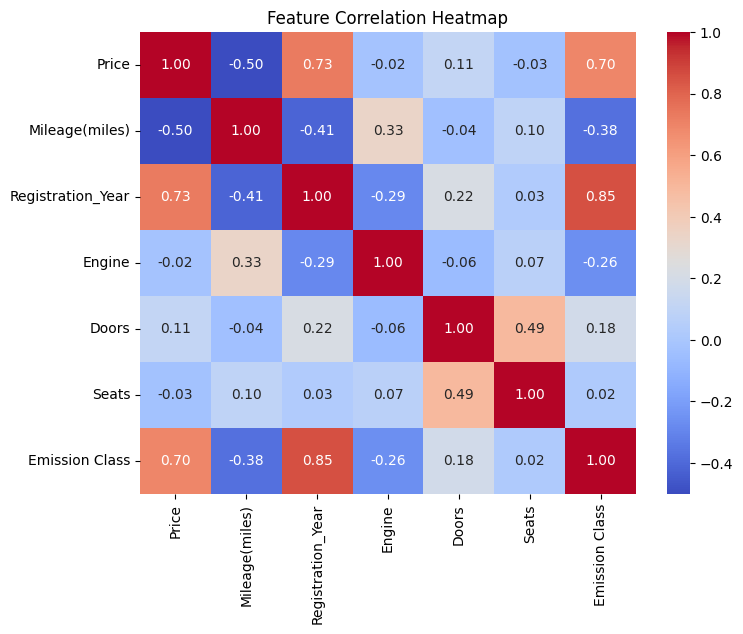

=== Price 기준 상관관계 ===
Price                1.000000
Registration_Year    0.726246
Emission Class       0.695129
Doors                0.113321
Engine              -0.024150
Seats               -0.027549
Mileage(miles)      -0.500788
Name: Price, dtype: float64


In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# 수치형 변수
num_cols = ['Price', 'Mileage(miles)', 'Registration_Year', 'Engine', 'Doors', 'Seats', 'Emission Class']

# 상관관계 계산
corr = merged[num_cols].corr()

# 히트맵 시각화
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

# Price 기준 상관관계
print("=== Price 기준 상관관계 ===")
print(corr['Price'].sort_values(ascending=False))


결과해석 :

차량의 신형 정도(연식 + 배출가스 등급)가 가장 중요한 가격 결정 요인으로 확인됨.
PCA에서 PC1이 이 두 변수를 중심으로 형성된 것과 일관된 결과.

주행거리(Mileage) 는 가격과 반비례 — 시간이 지날수록 감가가 누적되는 현실적인 패턴을 반영.

차체 크기 관련 변수(Doors, Seats, Engine) 는 상관이 약해, 영국 중고차 시장에서는 차량 크기보다는 상태와 신형도가 더 중요한 구매 요인으로 보임.